In [145]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from PIL import Image
from torch.utils.data import Subset

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, CyclicLR
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight


from glob import glob
from skimage.io import imread
from os import listdir

import time
import copy
from tqdm import tqdm

import medmnist
from medmnist import PathMNIST

In [146]:
train_dataset = PathMNIST(split="train", download=True)
val_dataset   = PathMNIST(split="val", download=True)
test_dataset  = PathMNIST(split="test", download=True)

In [147]:
set(train_dataset.labels.flatten())

{np.uint8(0),
 np.uint8(1),
 np.uint8(2),
 np.uint8(3),
 np.uint8(4),
 np.uint8(5),
 np.uint8(6),
 np.uint8(7),
 np.uint8(8)}

In [148]:
def filter_classes(dataset, classes):
    idx = np.isin(dataset.labels.flatten(), classes)
    indices = np.where(idx)[0]
    return Subset(dataset, indices)

chosen_classes = [0, 1]

train_dataset = filter_classes(train_dataset, chosen_classes)
val_dataset   = filter_classes(val_dataset, chosen_classes)
test_dataset  = filter_classes(test_dataset, chosen_classes)

print(len(train_dataset), len(val_dataset), len(test_dataset))

18875 2098 2185


In [149]:
def dataset_to_df(dataset, name="train"):
    labels = []
    indices = []

    for i in range(len(dataset)):
        img, label = dataset[i]
        labels.append(int(label))
        indices.append(i)

    df = pd.DataFrame({
        "set": name,
        "idx": indices,
        "target": labels
    })

    return df

df_train = dataset_to_df(train_dataset, "train")
df_val   = dataset_to_df(val_dataset, "val")
df_test  = dataset_to_df(test_dataset, "test")

data = pd.concat([df_train, df_val, df_test], ignore_index=True)

data.head()


,set,idx,target
0,train,0,0
1,train,1,1
2,train,2,1
3,train,3,1
4,train,4,0


# Analiza eksploracyjna danych

In [150]:
print("Train size:", len(train_dataset))
print("Val size:", len(val_dataset))
print("Test size:", len(test_dataset))

Train size: 18875
Val size: 2098
Test size: 2185


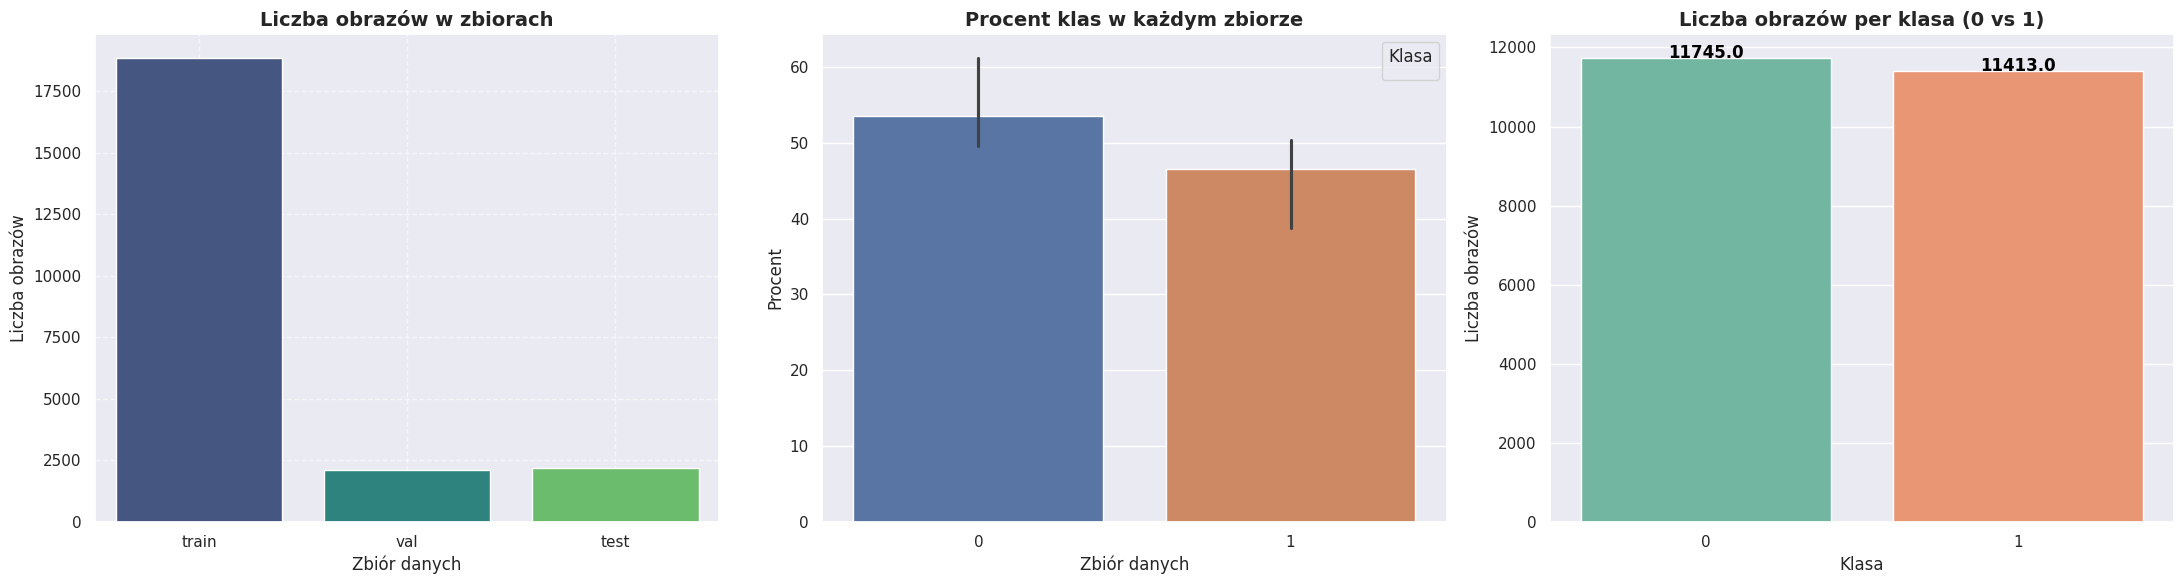

In [151]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 3, figsize=(22, 6))

# liczba obrazów per zbiór
sns.countplot(x="set", data=data, ax=ax[0], palette="viridis")
ax[0].set_xlabel("Zbiór danych", fontsize=12)
ax[0].set_ylabel("Liczba obrazów", fontsize=12)
ax[0].set_title("Liczba obrazów w zbiorach", fontsize=14, fontweight="bold")
ax[0].grid(True, linestyle="--", alpha=0.6)

# procent klasy 1 / 0 w każdym zbiorze
perc = data.groupby("set")["target"].value_counts(normalize=True).unstack() * 100
sns.barplot(data=perc, ax=ax[1])
ax[1].set_xlabel("Zbiór danych", fontsize=12)
ax[1].set_ylabel("Procent", fontsize=12)
ax[1].set_title("Procent klas w każdym zbiorze", fontsize=14, fontweight="bold")
ax[1].legend(title="Klasa")

# liczba obrazów w klasach
sns.countplot(x="target", data=data, ax=ax[2], palette="Set2")
ax[2].set_xlabel("Klasa", fontsize=12)
ax[2].set_ylabel("Liczba obrazów", fontsize=12)
ax[2].set_title("Liczba obrazów per klasa (0 vs 1)", fontsize=14, fontweight="bold")

for p in ax[2].patches:
    ax[2].annotate(f"{p.get_height()}",
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha="center", va="baseline", fontsize=12, color="black", fontweight="bold")

plt.tight_layout()
plt.show()

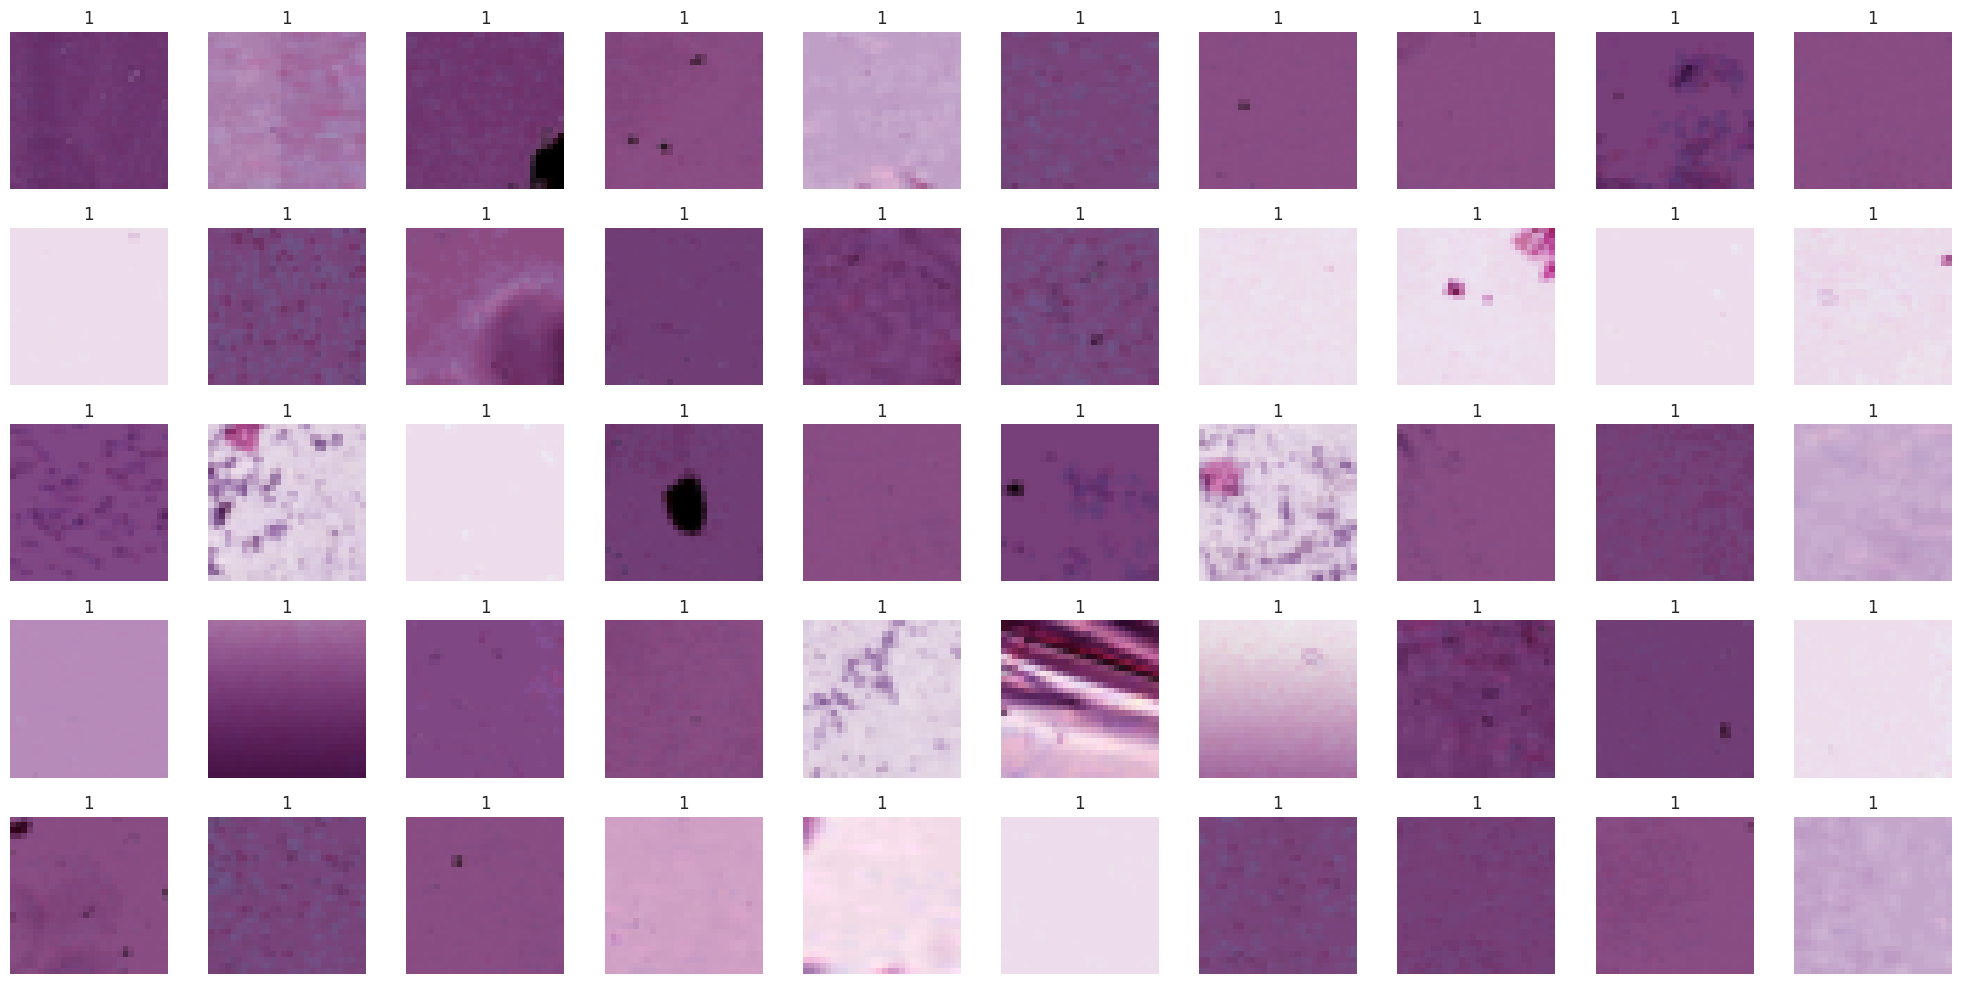

In [152]:
import numpy as np
import matplotlib.pyplot as plt

train_df = data[data.set == "train"].reset_index(drop=True)

pos_indices = train_df[train_df.target == 1].idx.values
neg_indices = train_df[train_df.target == 0].idx.values

# losujemy po 50 obrazów z każdej klasy
pos_selection = np.random.choice(pos_indices, size=50, replace=False)
neg_selection = np.random.choice(neg_indices, size=50, replace=False)

fig, ax = plt.subplots(5, 10, figsize=(20, 10))
ax = ax.ravel()

# pokazujemy najpierw klasę 1
for i, dataset_idx in enumerate(pos_selection):
    img, _ = train_dataset[dataset_idx]
    
    # jeśli jest Tensor -> zamieniamy na numpy
    if hasattr(img, "permute"):
        img = img.permute(1, 2, 0).numpy()
    
    ax[i].imshow(img, cmap=None)
    ax[i].set_title("1")
    ax[i].axis("off")

plt.tight_layout()
plt.show()

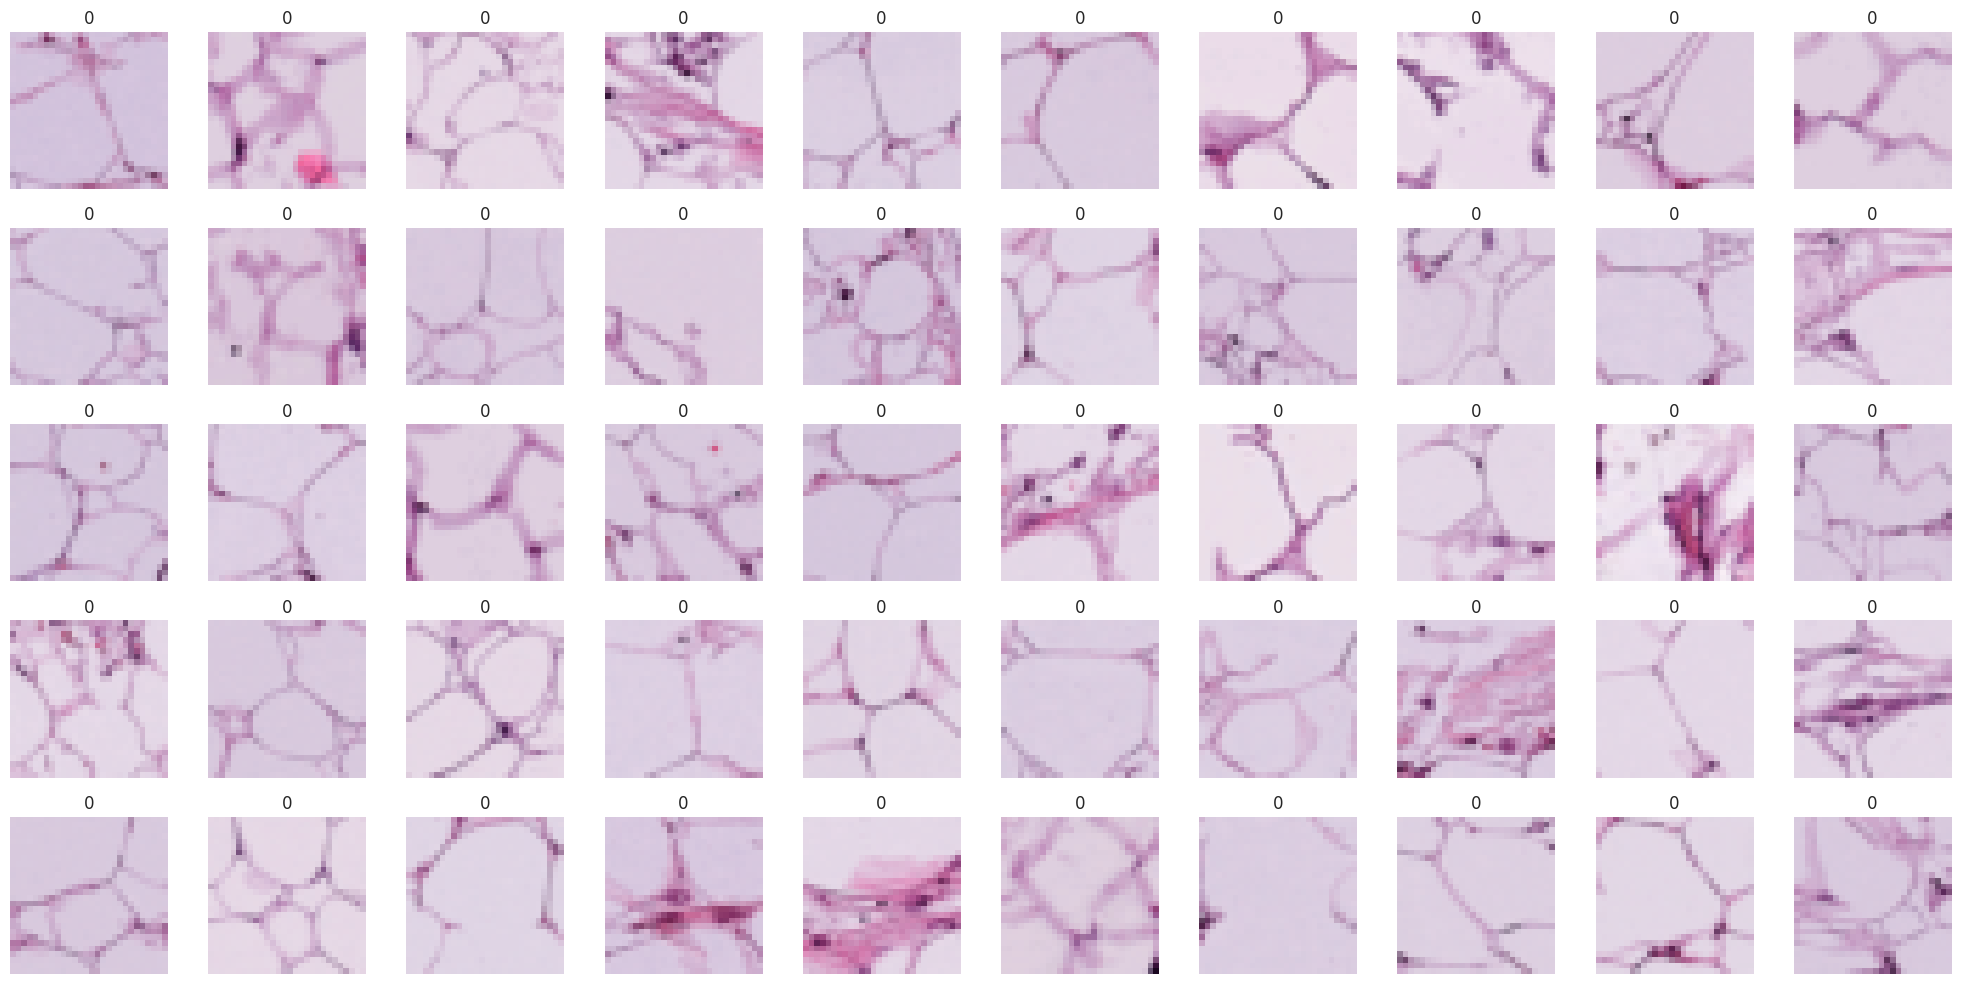

In [153]:
fig, ax = plt.subplots(5, 10, figsize=(20, 10))
ax = ax.ravel()

for i, dataset_idx in enumerate(neg_selection):
    img, _ = train_dataset[dataset_idx]
    
    if hasattr(img, "permute"):
        img = img.permute(1, 2, 0).numpy()
    
    ax[i].imshow(img, cmap=None)
    ax[i].set_title("0")
    ax[i].axis("off")

plt.tight_layout()
plt.show()

In [154]:
sizes = []

for i in range(len(train_dataset)):
    img, _ = train_dataset[i]

    if hasattr(img, "permute"):
        h, w = img.shape[1], img.shape[2]
    else:
        w, h = img.size

    sizes.append((h, w))

unique_sizes = set(sizes)
print("Unikalne rozmiary obrazów w train_dataset:", unique_sizes)

Unikalne rozmiary obrazów w train_dataset: {(28, 28)}


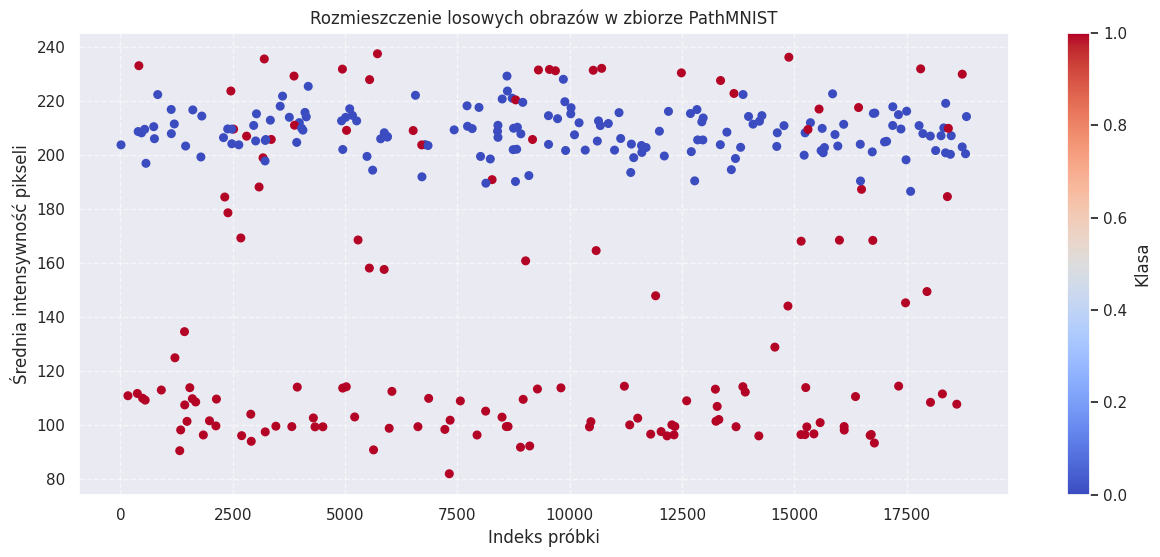

In [155]:
import matplotlib.pyplot as plt
import numpy as np

def plot_random_samples_scatter(dataset, n_samples=300):
  """
  Tworzy scatter plot losowych próbek z datasetu.
  X = indeks próbki
  Y = średnia intensywność pikseli obrazu
  Kolor = klasa
  """
  indices = np.random.choice(len(dataset), n_samples, replace=False)
  x_coords = []
  y_coords = []
  labels = []

  for idx in indices:
    img, label = dataset[idx]
    labels.append(label)
    
    if isinstance(img, np.ndarray):
      img_arr = img
    else:
      img_arr = np.array(img)

    y_coords.append(img_arr.mean())
    x_coords.append(idx)

  plt.figure(figsize=(15,6))
  scatter = plt.scatter(x_coords, y_coords, c=labels, cmap="coolwarm", s=30)
  plt.colorbar(scatter, label="Klasa")
  plt.xlabel("Indeks próbki")
  plt.ylabel("Średnia intensywność pikseli")
  plt.title("Rozmieszczenie losowych obrazów w zbiorze PathMNIST")
  plt.grid(True, linestyle="--", alpha=0.6)
  plt.show()

plot_random_samples_scatter(train_dataset, n_samples=300)

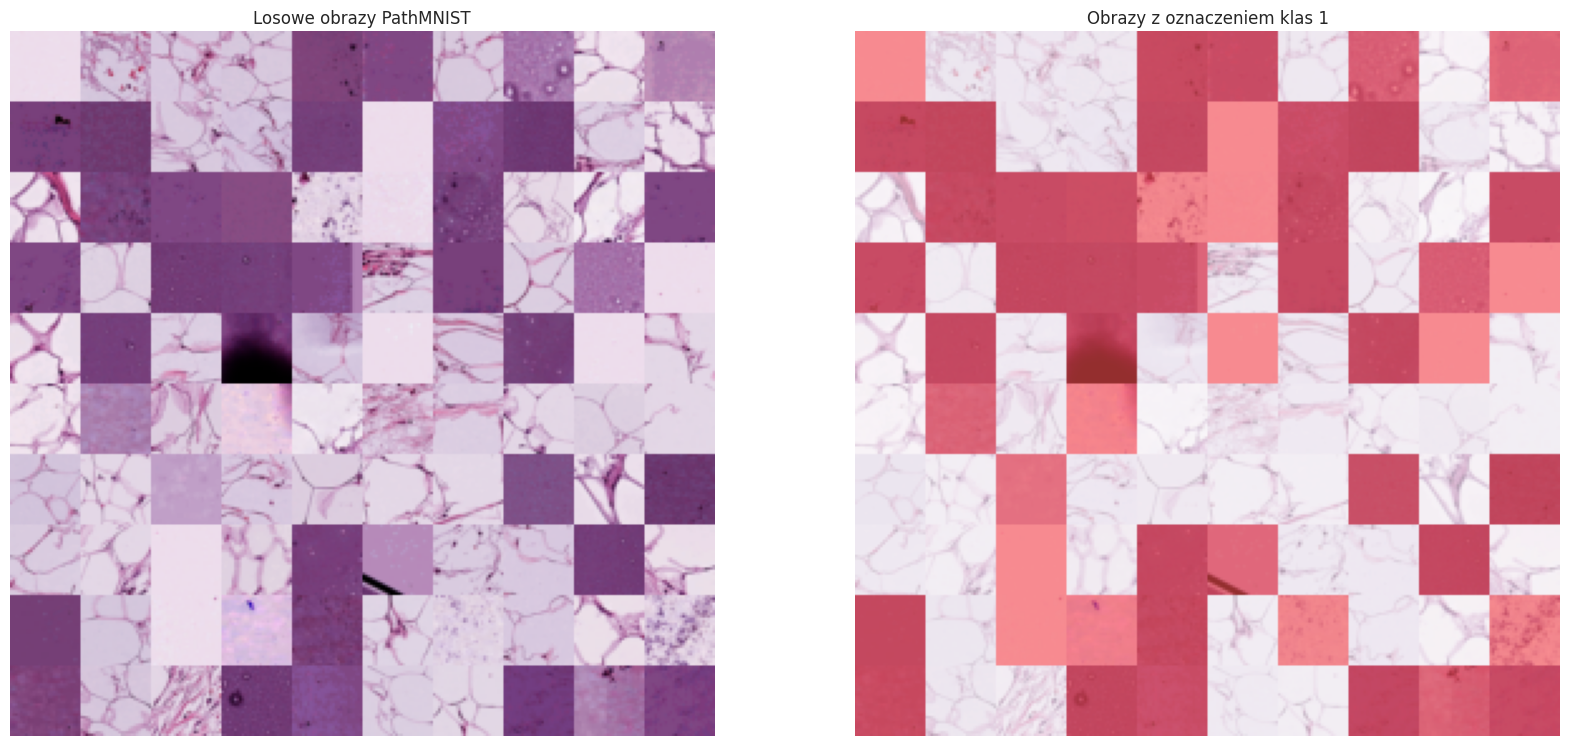

In [156]:
import numpy as np
import matplotlib.pyplot as plt

def visualise_pathmnist_grid(dataset, n_rows=10, n_cols=10):
    """
    Tworzy obraz złożony z patchy (28x28) dla losowych obrazów w zbiorze.
    Oznacza klasy kolorem czerwonym dla 1, brak oznaczenia dla 0.
    """
    n_patches = n_rows * n_cols
    indices = np.random.choice(len(dataset), n_patches, replace=False)

    patch_size = 28
    grid_height = n_rows * patch_size
    grid_width = n_cols * patch_size

    # siatka pełna: białe tło
    grid = 255 * np.ones((grid_height, grid_width, 3), dtype=np.uint8)

    # maska: zaznaczamy klasy 1 na czerwono
    mask = 255 * np.ones_like(grid)

    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        
        # PIL -> numpy
        if not isinstance(img, np.ndarray):
            img = np.array(img)
        
        # jeśli obraz w grayscale (1 kanał), zamieniamy na 3 kanały
        if len(img.shape) == 2:
            img = np.stack([img]*3, axis=-1)
        
        row = i // n_cols
        col = i % n_cols
        y_start = row * patch_size
        y_end   = y_start + patch_size
        x_start = col * patch_size
        x_end   = x_start + patch_size

        grid[y_start:y_end, x_start:x_end] = img

        if label == 1:
            mask[y_start:y_end, x_start:x_end, 0] = 255   # czerwony
            mask[y_start:y_end, x_start:x_end, 1] = 0
            mask[y_start:y_end, x_start:x_end, 2] = 0

    return grid, mask

# wywołanie
grid, mask = visualise_pathmnist_grid(train_dataset, n_rows=10, n_cols=10)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(grid)
ax[0].set_title("Losowe obrazy PathMNIST")
ax[0].axis("off")

ax[1].imshow(grid, alpha=0.7)
ax[1].imshow(mask, alpha=0.4)
ax[1].set_title("Obrazy z oznaczeniem klas 1")
ax[1].axis("off")

plt.show()


In [157]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [158]:
class PathMNISTDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]

        if isinstance(img, np.ndarray):
            img = Image.fromarray(img.astype(np.uint8))
        elif isinstance(img, torch.Tensor):
            img = transforms.ToPILImage()(img)

        if self.transform:
            img = self.transform(img)

        return img, int(label)

In [159]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

all_labels = []
for i in range(len(train_dataset)):
    _, label = train_dataset[i]
    all_labels.append(int(label))

all_labels = np.array(all_labels)

weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0, 1]),
    y=all_labels
)

class_weights = torch.tensor(weights, dtype=torch.float32, device=device)

print("CLASS WEIGHTS:", class_weights)

CLASS WEIGHTS: tensor([1.0076, 0.9925])


In [160]:
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

train_dataset = PathMNISTDataset(train_dataset, transform=train_transform)
val_dataset = PathMNISTDataset(val_dataset, transform=train_transform)
test_dataset  = PathMNISTDataset(test_dataset,  transform=train_transform)

In [161]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

dataloaders = {"train": train_loader, "val": val_loader, "test": test_loader}

print(len(dataloaders["train"]), len(dataloaders["val"]), len(dataloaders["test"]))

589 66 69


In [162]:
dataset_sizes = {
    "train": len(train_dataset),
    "val": len(val_dataset),
    "test": len(test_dataset)
}


In [163]:
import torch
import torch.nn as nn
import torchvision

NUM_CLASSES = 2

# pretrenowany ResNet18
model = torchvision.models.resnet18(pretrained=True)

# zamiana warstwy FC
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.5),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256, NUM_CLASSES)
)

# Inicjalizacja wag dla nowych warstw
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [164]:
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [165]:
def f1_score(preds, targets):
    tp = (preds * targets).sum().to(torch.float32)
    fp = ((1 - targets) * preds).sum().to(torch.float32)
    fn = (targets * (1 - preds)).sum().to(torch.float32)

    epsilon = 1e-7

    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    f1 = 2 * precision * recall / (precision + recall + epsilon)
    return f1

In [166]:
def train_loop(model, criterion, optimizer, scheduler=None, num_epochs=3):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    loss_dict = {"train": [], "val": []}

    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs-1}")
        print("-"*10)

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for imgs, labels in tqdm(dataloaders[phase]):
                imgs = imgs.to(device, dtype=torch.float32)
                labels = labels.to(device, dtype=torch.long)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(imgs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                        if scheduler:
                            scheduler.step()

                running_loss += loss.item() * imgs.size(0)
                running_corrects += torch.sum(preds == labels)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            loss_dict[phase].append(epoch_loss)
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print("Training complete.")
    print(f"Best val Acc: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)

    return model, loss_dict


In [167]:
start_lr = 1e-6
end_lr = 0.1

In [168]:
def get_lr_search_scheduler(optimizer, min_lr, max_lr, max_iterations):
    return torch.optim.lr_scheduler.CyclicLR(
        optimizer,
        base_lr=min_lr,
        max_lr=max_lr,
        step_size_up=max_iterations,
        step_size_down=max_iterations,
        mode="triangular"
    )


def get_scheduler(optimiser, min_lr, max_lr, stepsize):
    stepsize_up = max(1, int(stepsize / 2))

    return torch.optim.lr_scheduler.CyclicLR(
        optimizer=optimiser,
        base_lr=min_lr,
        max_lr=max_lr,
        step_size_up=stepsize_up,
        step_size_down=stepsize_up,
        mode="triangular"
    )


In [169]:
import torch.optim as optim

lr_find_epochs = 1

optimizer = optim.SGD(model.fc.parameters(), lr=start_lr)

scheduler = get_lr_search_scheduler(
    optimizer,
    start_lr,
    end_lr,
    lr_find_epochs * len(train_loader)
)

# model, loss_dict = train_loop(
#     model,
#     criterion,
#     optimizer,
#     scheduler=scheduler,
#     num_epochs=lr_find_epochs
# )

In [170]:
# TEST run

_original_dataloaders = dataloaders
_original_dataset_sizes = dataset_sizes.copy()

from torch.utils.data import Subset as _Subset
import numpy as _np


_n_train_samples = min(256, len(train_dataset))
_n_val_samples = min(64, len(val_dataset))

_train_subset = _Subset(train_dataset, list(range(_n_train_samples)))
_val_subset = _Subset(val_dataset, list(range(_n_val_samples)))

_small_train_loader = DataLoader(_train_subset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
_small_val_loader = DataLoader(_val_subset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

dataloaders = {"train": _small_train_loader, "val": _small_val_loader}
dataset_sizes = {"train": len(_train_subset), "val": len(_val_subset)}

print(f"TEST: running short training with train samples={dataset_sizes['train']}, val samples={dataset_sizes['val']}")

_test_model, _test_loss = train_loop(model, criterion, optimizer, scheduler=None, num_epochs=1)

dataloaders = _original_dataloaders
dataset_sizes = _original_dataset_sizes

TEST: running short training with train samples=256, val samples=64
Epoch 0/0
----------


100%|██████████| 8/8 [00:25<00:00,  3.22s/it]


train Loss: 1.3552 Acc: 0.4531


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]

val Loss: 0.5634 Acc: 0.7500

Training complete.
Best val Acc: 0.7500


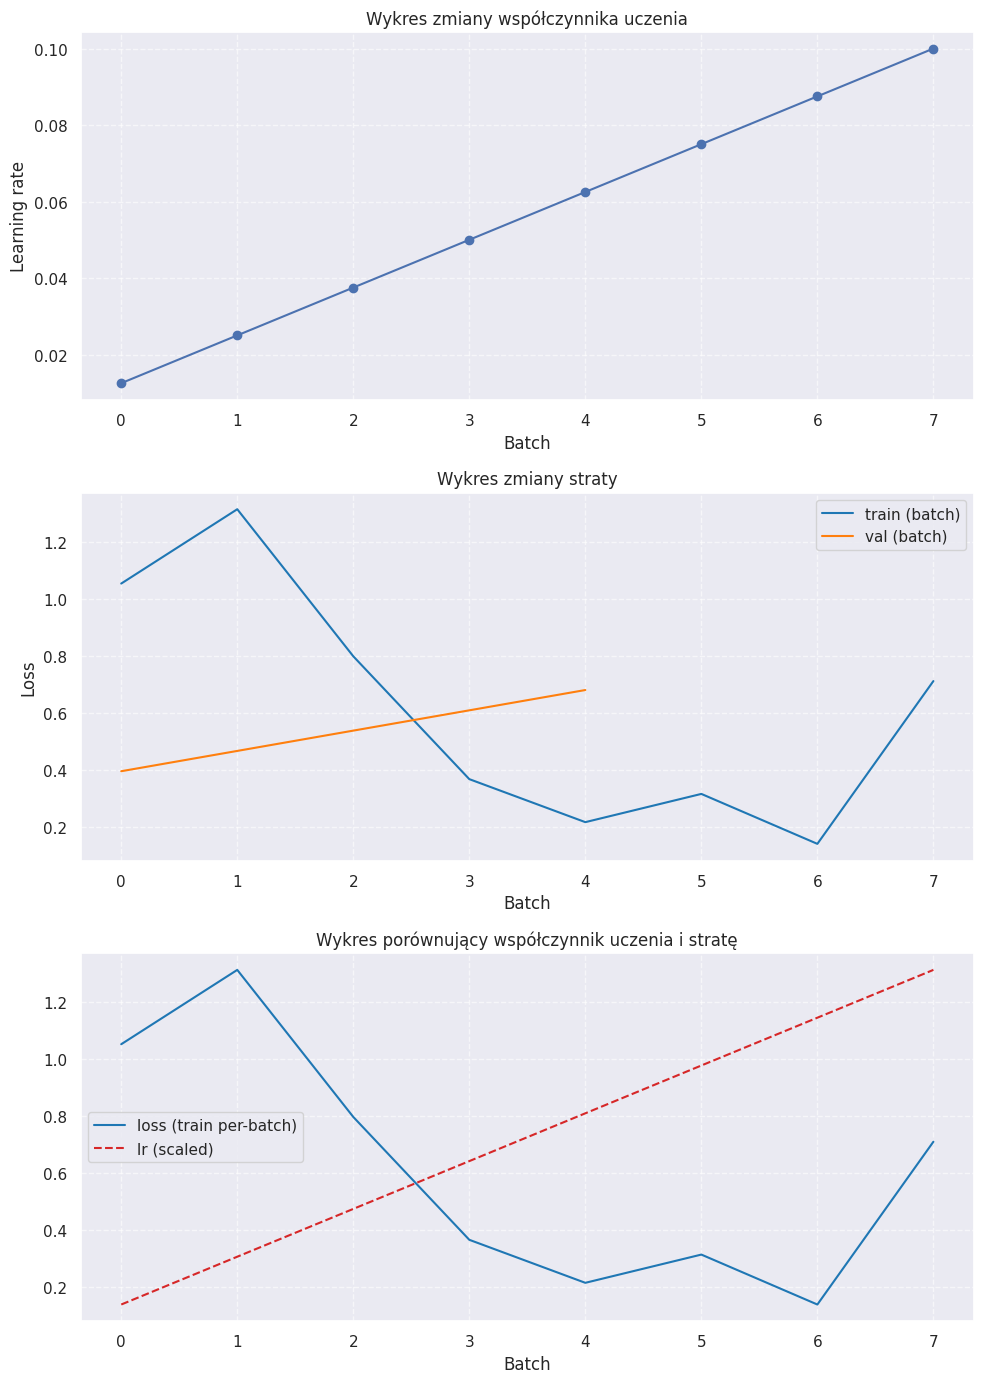

In [171]:
from torch.utils.data import Subset as _Subset
import torch.optim as _optim
import matplotlib.pyplot as _plt

_n_train = min(256, len(train_dataset))
_n_val = min(64, len(val_dataset))

_train_subset = _Subset(train_dataset, list(range(_n_train)))
_val_subset = _Subset(val_dataset, list(range(_n_val)))

_small_train_loader = DataLoader(_train_subset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
_small_val_loader = DataLoader(_val_subset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

_temp_optimizer = _optim.SGD(model.fc.parameters(), lr=start_lr)
_temp_scheduler = get_lr_search_scheduler(_temp_optimizer, start_lr, end_lr, max_iterations=len(_small_train_loader))

lr_history = []
train_loss_history = []
val_loss_history = []

model.train()
for batch_idx, (imgs, labels) in enumerate(_small_train_loader):
    imgs = imgs.to(device, dtype=torch.float32)
    labels = labels.to(device, dtype=torch.long)

    _temp_optimizer.zero_grad()
    outputs = model(imgs)
    loss = criterion(outputs, labels)
    loss.backward()
    _temp_optimizer.step()
    if _temp_scheduler is not None:
        _temp_scheduler.step()

    lr_history.append(_temp_optimizer.param_groups[0]["lr"])
    train_loss_history.append(loss.item())

model.eval()
with torch.no_grad():
    for imgs, labels in _small_val_loader:
        imgs = imgs.to(device, dtype=torch.float32)
        labels = labels.to(device, dtype=torch.long)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        val_loss_history.append(loss.item())

_plt.rcParams.update({'font.size': 12})
fig, axes = _plt.subplots(3, 1, figsize=(10, 14))

axes[0].plot(lr_history, marker='o')
axes[0].set_title('Wykres zmiany współczynnika uczenia')
axes[0].set_xlabel('Batch')
axes[0].set_ylabel('Learning rate')
axes[0].grid(True, linestyle='--', alpha=0.6)

axes[1].plot(train_loss_history, label='train (batch)', color='tab:blue')
if len(val_loss_history) > 0:
    val_x = _range = list(range(0, len(train_loss_history), max(1, len(train_loss_history)//len(val_loss_history))))
    if len(val_x) >= len(val_loss_history):
        axes[1].plot(val_x[:len(val_loss_history)], val_loss_history, label='val (batch)', color='tab:orange')
    else:
        axes[1].plot(range(len(val_loss_history)), val_loss_history, label='val (batch)', color='tab:orange')

axes[1].set_title('Wykres zmiany straty')
axes[1].set_xlabel('Batch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.6)

if len(lr_history) > 0 and len(train_loss_history) > 0:
    lr_arr = _np.array(lr_history)
    loss_arr = _np.array(train_loss_history)
    lr_scaled = (lr_arr - lr_arr.min()) / (lr_arr.max() - lr_arr.min() + 1e-12)
    lr_scaled = lr_scaled * (loss_arr.max() - loss_arr.min()) + loss_arr.min()

    axes[2].plot(loss_arr, label='loss (train per-batch)', color='tab:blue')
    axes[2].plot(lr_scaled, label='lr (scaled)', color='tab:red', linestyle='--')
    axes[2].set_title('Wykres porównujący współczynnik uczenia i stratę')
    axes[2].set_xlabel('Batch')
    axes[2].legend()
    axes[2].grid(True, linestyle='--', alpha=0.6)
else:
    axes[2].text(0.5, 0.5, 'Brak danych do wykresu', ha='center')

_plt.tight_layout()
_plt.show()